# Imports

In [ ]:
import sys
sys.path.insert(0, '..')

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from src.beam import Beam
from src.error_analysis import NumericalErrorAnalysis

# Beam Parameters

In [7]:
# -------------------------
# Realistic parameter set (SI)
# -------------------------
L = 1.5                      # m
rho = 2700.0                 # kg/m^3 (aluminum)
E = 70e9                     # Pa
b = 0.05                     # m (beam width)
h = 0.01                     # m (beam thickness)
A = b*h                      # m^2
I = b*h**3/12                # m^4
rhoA = rho*A                 # kg/m
EI = E*I                     # N*m^2

cd = 2.0                     # N*s/m^2 (moderate damping baseline)
alpha = 0.005                # m (5 mm initial tip-ish amplitude scale)
m = 401                      # grid points (fine enough for D4)

# 1. Uniform step load

In [8]:
# -------------------------
# Case 1: uniform step load
# -------------------------
# q(x,t) is distributed load per length [N/m]
# Example: 20 N/m turns on at t=0.05 s
prob = Beam(
    L=L, m=m,
    rhoA=rhoA, EI=EI, cd=cd,
    alpha=alpha,
    forcing_type="step",
    forcing_params={"q0": 20.0, "t0": 0.05},
)

## 1.1 Numerical solver

In [9]:
# Pick solve_trapezoid() or solve_backward_euler() method

t, W_hist, V_hist = prob.solve_trapezoid(dt=5e-4, Tfinal=10.0, store_every=50)
# t, W_hist, V_hist = prob.solve_backward_euler(dt=5e-4, Tfinal=10.0, store_every=50)

## 1.2 Plot

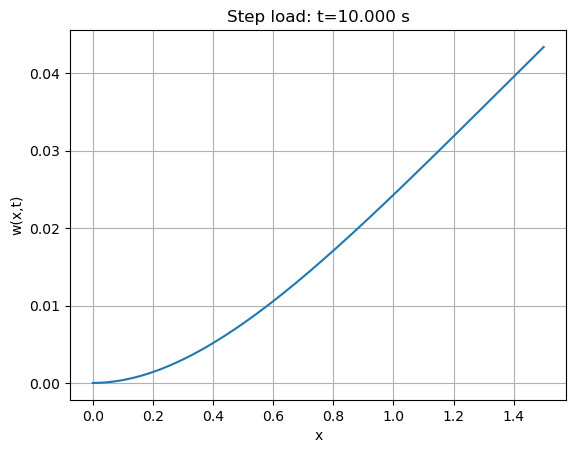

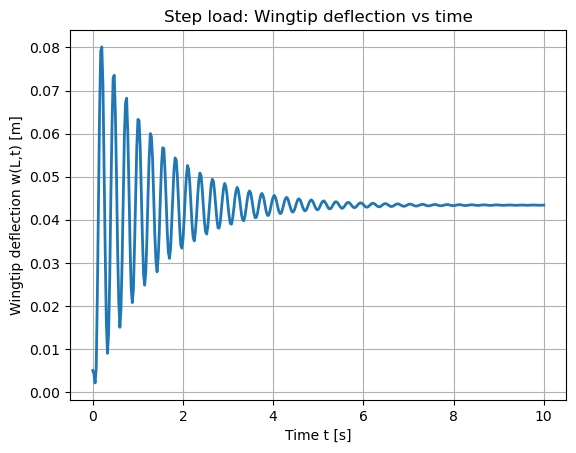

In [10]:
prob.plot_snapshot(W_hist[-1], title=f"Step load: t={t[-1]:.3f} s")
prob.plot_wingtip_amplitude(t, W_hist, title="Step load: Wingtip deflection vs time")

## 1.3 Animation

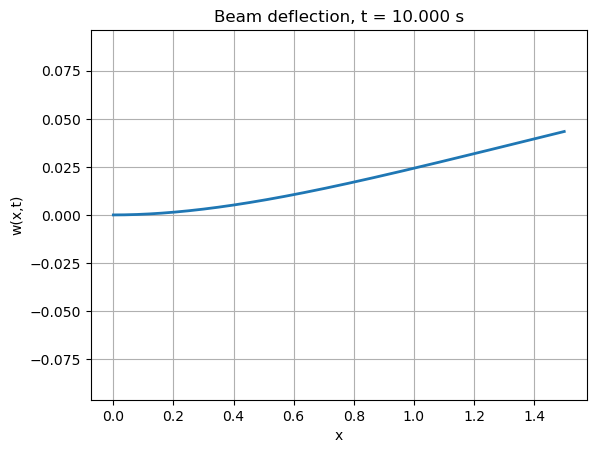

Saved animation to: ../data/beam_step.gif


In [11]:
prob.animate_deflection(
    t,
    W_hist,
    interval=30,
    file_name="beam_step.gif"
)

# 2. Localized tip gust

In [12]:
# -------------------------
# Case 2: localized tip gust (Gaussian pulse)
# -------------------------
# Tip region length dx_tip = 0.05 L (small region near free end)
# Choose a pulse so that total peak force is ~10 N.
# If q_amp is the peak N/m applied over dx_tip, peak total force is approx q_amp * dx_tip.
dx_tip = 0.05 * L            # m
target_peak_force = 10.0     # N
q_amp = target_peak_force / dx_tip  # N/m

gust = Beam(
    L=L, m=m,
    rhoA=rhoA, EI=EI, cd=cd,
    alpha=alpha,
    forcing_type="tip",
    forcing_params={
        "dx_tip": dx_tip,
        "pulse": "gaussian",
        "q_amp": q_amp,       # N/m (chosen so peak total force ~10 N)
        "t_center": 0.20,     # s
        "sigma": 0.02         # s (short-duration gust)
    },
)

## 2.2 Numerical solver

In [13]:
# Pick solve_trapezoid() or solve_backward_euler() method

t2, W_hist2, V_hist2 = gust.solve_trapezoid(dt=5e-4, Tfinal=10.0, store_every=50)
# t2, W_hist2, V_hist2 = gust.solve_backward_euler(dt=5e-4, Tfinal=10.0, store_every=50)

## 2.2 Plot

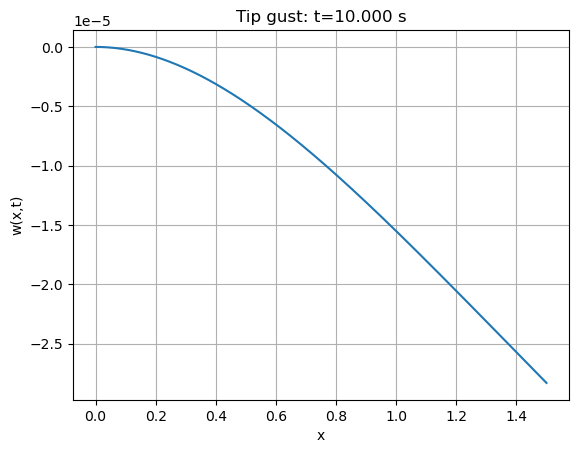

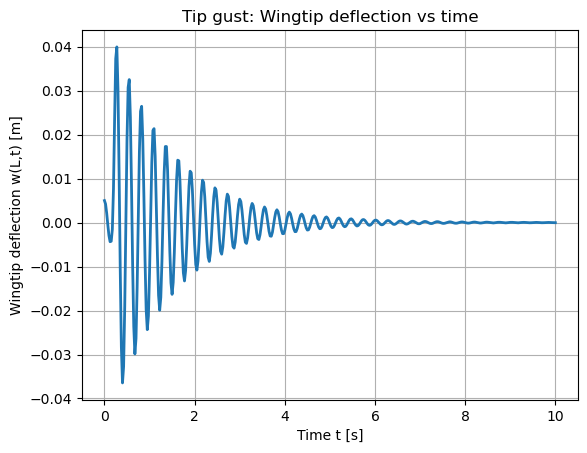

In [14]:
gust.plot_snapshot(W_hist2[-1], title=f"Tip gust: t={t2[-1]:.3f} s")
gust.plot_wingtip_amplitude(t2, W_hist2, title="Tip gust: Wingtip deflection vs time")

## 2.3 Animation

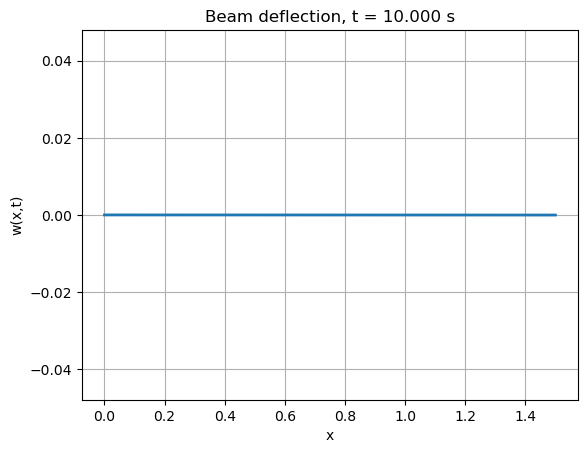

Saved animation to: ../data/beam_gust.gif


In [15]:
gust.animate_deflection(
    t2,
    W_hist2,
    interval=30,
    file_name="beam_gust.gif"
)

# Test Peak Wingtip Deflection and Dominant Frequencies vs different EI's

In [ ]:
dt = 5e-4
Tfinal = 10.0
store_every = 1

# -------------------------
# Stiffness sweep: vary EI, keep everything else the same
# -------------------------
EI0 = EI
EI_mult = np.array([0.5, 1.0, 2.0, 4.0])   # adjust as you like
EI_list = EI0 * EI_mult

w_tip_max_list = []
f_dom_list = []

# (optional) save time histories for overlay figure
tip_histories = []

for EI_i in EI_list:
    # --- re-use the exact same gust configuration ---
    dx_tip = 0.05 * L
    target_peak_force = 10.0
    q_amp = target_peak_force / dx_tip

    gust_i = Beam(
        L=L, m=m,
        rhoA=rhoA, EI=EI_i, cd=cd,
        alpha=alpha,
        forcing_type="tip",
        forcing_params={
            "dx_tip": dx_tip,
            "pulse": "gaussian",
            "q_amp": q_amp,
            "t_center": 0.20,
            "sigma": 0.02
        },
    )

    # solve (Backward Euler)
    t, W_hist, V_hist = gust_i.solve_backward_euler(dt=dt, Tfinal=Tfinal, store_every=store_every)

    # wingtip deflection time history
    w_tip = W_hist[:, -1]
    tip_histories.append((EI_i, t, w_tip))

    # ---- metric 1: peak wingtip deflection ----
    w_tip_max_list.append(np.max(np.abs(w_tip)))

    # ---- metric 2: dominant frequency via FFT ----
    dt_plot = t[1] - t[0]
    w_detrend = w_tip - np.mean(w_tip)
    freqs = np.fft.rfftfreq(len(w_detrend), d=dt_plot)
    mag = np.abs(np.fft.rfft(w_detrend))

    # ignore DC term
    k = np.argmax(mag[1:]) + 1
    f_dom_list.append(freqs[k])

w_tip_max_list = np.array(w_tip_max_list, dtype=float)
f_dom_list     = np.array(f_dom_list, dtype=float)


### Plot 1 (Report Figure): Peak tip deflection vs EI

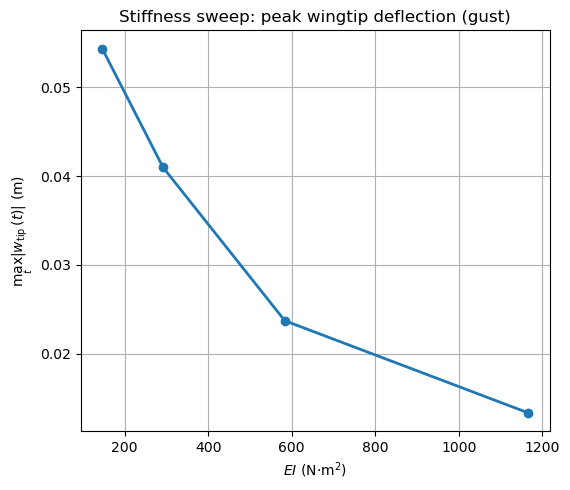

In [ ]:
fig, ax = plt.subplots(figsize=(5.8, 5.0), tight_layout=True)
ax.plot(EI_list, w_tip_max_list, marker="o", linewidth=2)
ax.set_xlabel(r"$EI$ (N$\cdot$m$^2$)")
ax.set_ylabel(r"$\max_t |w_{\mathrm{tip}}(t)|$ (m)")
ax.set_title(r"Stiffness sweep: peak wingtip deflection (gust)")
ax.grid(True, which="both")
plt.savefig("../data/stiffness_sweep_peak_tip_deflection.pdf", bbox_inches="tight")
plt.show()


### Plot 2: Dominant frequency vs EI

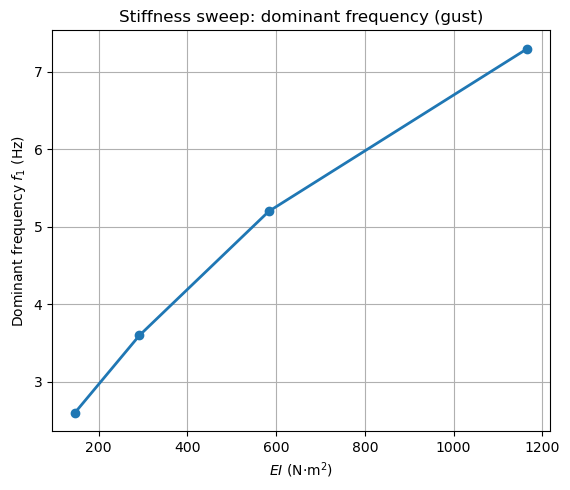

In [ ]:
fig, ax = plt.subplots(figsize=(5.8, 5.0), tight_layout=True)
ax.plot(EI_list, f_dom_list, marker="o", linewidth=2)
ax.set_xlabel(r"$EI$ (N$\cdot$m$^2$)")
ax.set_ylabel(r"Dominant frequency $f_1$ (Hz)")
ax.set_title(r"Stiffness sweep: dominant frequency (gust)")
ax.grid(True, which="both")
plt.savefig("../data/stiffness_sweep_dominant_frequency.pdf", bbox_inches="tight")
plt.show()


### Overlay plot $w_{tip}(t)$ with different EI

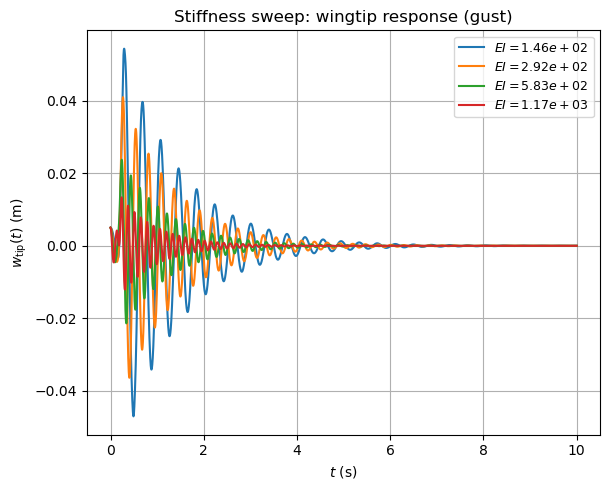

In [ ]:
fig, ax = plt.subplots(figsize=(6.2, 5.0), tight_layout=True)
for EI_i, t, w_tip in tip_histories:
    ax.plot(t, w_tip, linewidth=1.5, label=rf"$EI={EI_i:.2e}$")
ax.set_xlabel(r"$t$ (s)")
ax.set_ylabel(r"$w_{\mathrm{tip}}(t)$ (m)")
ax.set_title(r"Stiffness sweep: wingtip response (gust)")
ax.grid(True, which="both")
ax.legend(loc="best", fontsize=9)
plt.savefig("../data/stiffness_sweep_tip_time_histories.pdf", bbox_inches="tight")
plt.show()


# Damping sweep experiment

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Damping sweep settings
# -------------------------
dt = 5e-4
Tfinal = 10.0
store_every = 1

cd0 = cd
cd_mult = np.array([0.0, 0.5, 1.0, 2.0, 4.0])
cd_list = cd0 * cd_mult

threshold_frac = 0.10  # settling threshold as fraction of BASELINE peak

# -------------------------
# Helper: build gust Beam (keeps your exact format)
# -------------------------
def make_gust_beam(cd_value: float):
    dx_tip = 0.05 * L
    target_peak_force = 10.0
    q_amp = target_peak_force / dx_tip

    return Beam(
        L=L, m=m,
        rhoA=rhoA, EI=EI, cd=cd_value,
        alpha=alpha,
        forcing_type="tip",
        forcing_params={
            "dx_tip": dx_tip,
            "pulse": "gaussian",
            "q_amp": q_amp,
            "t_center": 0.20,
            "sigma": 0.02
        },
    )

# -------------------------
# Baseline run to define a consistent threshold (cd = cd0)
# -------------------------
gust_base = make_gust_beam(cd0)
t0, W0, V0 = gust_base.solve_backward_euler(dt=dt, Tfinal=Tfinal, store_every=store_every)
w0_abs = np.abs(W0[:, -1])
w_peak_baseline = np.max(w0_abs)
thresh = threshold_frac * w_peak_baseline

print(f"Baseline peak = {w_peak_baseline:.6e} m, threshold ({threshold_frac*100:.0f}%) = {thresh:.6e} m")

# -------------------------
# Sweep over damping values
# -------------------------
w_tip_max_list = []
settle_time_list = []
tip_histories = []  # optional for overlay plot

for cd_i in cd_list:
    gust_i = make_gust_beam(cd_i)

    # solve (Backward Euler)
    t, W_hist, V_hist = gust_i.solve_backward_euler(dt=dt, Tfinal=Tfinal, store_every=store_every)

    # wingtip deflection
    w_tip = W_hist[:, -1]
    tip_histories.append((cd_i, t, w_tip))

    # metric 1: peak absolute wingtip deflection
    w_abs = np.abs(w_tip)
    w_peak = np.max(w_abs)
    w_tip_max_list.append(w_peak)

    # metric 2: settling time (first time after peak such that it stays below thresh thereafter)
    i_peak = np.argmax(w_abs)
    post = w_abs[i_peak:]

    settle_idx = None
    for j in range(len(post)):
        if np.all(post[j:] <= thresh):
            settle_idx = j
            break

    if settle_idx is None:
        settle_time_list.append(np.nan)  # didn't settle within Tfinal
    else:
        settle_time_list.append(t[i_peak + settle_idx])

w_tip_max_list = np.array(w_tip_max_list, dtype=float)
settle_time_list = np.array(settle_time_list, dtype=float)


Baseline peak = 4.096543e-02 m, threshold (10%) = 4.096543e-03 m


### Plot A: Peak wingtip deflection vs $c_d$

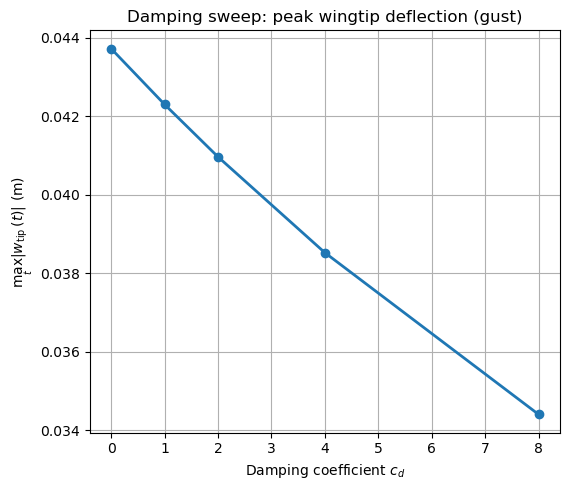

In [ ]:
# -------------------------
# Plot A: Peak wingtip deflection vs cd
# -------------------------
fig, ax = plt.subplots(figsize=(5.8, 5.0), tight_layout=True)
ax.plot(cd_list, w_tip_max_list, marker="o", linewidth=2)
ax.set_xlabel(r"Damping coefficient $c_d$")
ax.set_ylabel(r"$\max_t |w_{\mathrm{tip}}(t)|$ (m)")
ax.set_title(r"Damping sweep: peak wingtip deflection (gust)")
ax.grid(True, which="both")
plt.savefig("../data/damping_sweep_peak_tip_deflection.pdf", bbox_inches="tight")
plt.show()

### Plot B: Decay time vs $c_d$

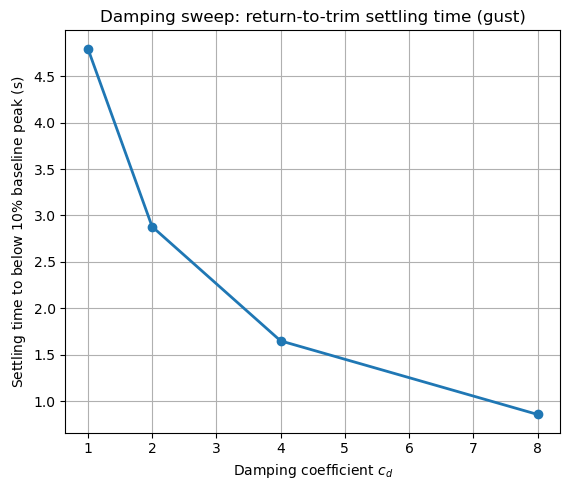

In [ ]:
# -------------------------
# Plot B: Settling time vs cd
# -------------------------
fig, ax = plt.subplots(figsize=(5.8, 5.0), tight_layout=True)
ax.plot(cd_list, settle_time_list, marker="o", linewidth=2)
ax.set_xlabel(r"Damping coefficient $c_d$")
ax.set_ylabel(r"Settling time to below $10\%$ baseline peak (s)")
ax.set_title(r"Damping sweep: return-to-trim settling time (gust)")
ax.grid(True, which="both")
plt.savefig("../data/damping_sweep_settling_time.pdf", bbox_inches="tight")
plt.show()


### Overlay time histories for intuition

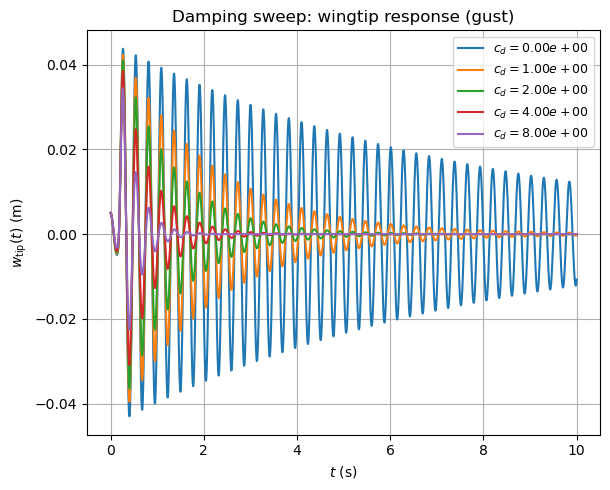

In [ ]:
fig, ax = plt.subplots(figsize=(6.2, 5.0), tight_layout=True)
for cd_i, t, w_tip in tip_histories:
    ax.plot(t, w_tip, linewidth=1.5, label=rf"$c_d={cd_i:.2e}$")

ax.set_xlabel(r"$t$ (s)")
ax.set_ylabel(r"$w_{\mathrm{tip}}(t)$ (m)")
ax.set_title(r"Damping sweep: wingtip response (gust)")
ax.grid(True, which="both")
ax.legend(loc="best", fontsize=9)

plt.savefig("../data/damping_sweep_tip_time_histories.pdf", bbox_inches="tight")
plt.show()
